In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

In [2]:
client = Socrata("data.cityofnewyork.us", None)
results = client.get_all("8vv7-7wx3")

emc_df = pd.DataFrame.from_records(results)
emc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 5 columns):
date_and_time         16950 non-null object
email_body            16422 non-null object
notification_title    16950 non-null object
notificationtype      16950 non-null object
record_id             16950 non-null object
dtypes: object(5)
memory usage: 662.2+ KB


In [3]:
emc_df["email_body"]=emc_df["email_body"].apply(lambda x: np.NaN if x== "[blank]" else x)
emc_df = emc_df.dropna()
emc_df.duplicated(keep = "first")
emc_df['notificationtype'] = emc_df['notificationtype'].astype('category')
emc_df['date_and_time'] = pd.to_datetime(emc_df['date_and_time'])
emc_df['date_and_time'] = emc_df['date_and_time'].dt.date

In [4]:
import datetime
import time
start1='2019-01-01'
end1='2019-04-30'
start_date1=datetime.date(*map(int,start1.split('-')))
end_date1=datetime.date(*map(int,end1.split('-')))

start2='2020-01-01'
end2='2020-05-07'
start_date2=datetime.date(*map(int,start2.split('-')))
end_date2=datetime.date(*map(int,end2.split('-')))

df_19 = emc_df[emc_df['date_and_time'].apply(lambda x: x > start_date1 and x < end_date1)]
df_20 = emc_df[emc_df['date_and_time'].apply(lambda x: x > start_date2 and x < end_date2)]

In [5]:
counts_19 = df_19.groupby(['notificationtype'])['record_id'].count().reset_index(name='total_count')
counts_20 = df_20.groupby(['notificationtype'])['record_id'].count().reset_index(name='total_count')

In [6]:
counts_19 = counts_19.loc[lambda counts_20: counts_20['total_count'] > 0]
counts_20 = counts_20.loc[lambda counts_20: counts_20['total_count'] > 0]
counts_19.rename(columns={'total_count':'total_count_19'}, inplace=True)
counts_20.rename(columns={'total_count':'total_count_20'}, inplace=True)

In [7]:
join_1920 = counts_20.join(counts_19.set_index('notificationtype'), on='notificationtype')
join_1920['total_count_19'].fillna(0, inplace = True)

In [8]:
join_1920['difference'] = join_1920['total_count_20'] - join_1920['total_count_19']
join_1920 = join_1920[join_1920["difference"].apply(lambda x : x != 0)]
join_1920

,notificationtype,total_count_20,total_count_19,difference
1,Drills / Exercises,1,6.0,-5.0
2,Environmental,47,40.0,7.0
3,Fire,24,36.0,-12.0
5,Mass Transit Disruption,122,111.0,11.0
6,Mass Transit Restoration,93,85.0,8.0
7,Missing Adult,55,59.0,-4.0
8,Missing Child / Adolescent,8,12.0,-4.0
9,Parking,8,3.0,5.0
11,Public Health,115,0.0,115.0
12,Road Closure,567,395.0,172.0


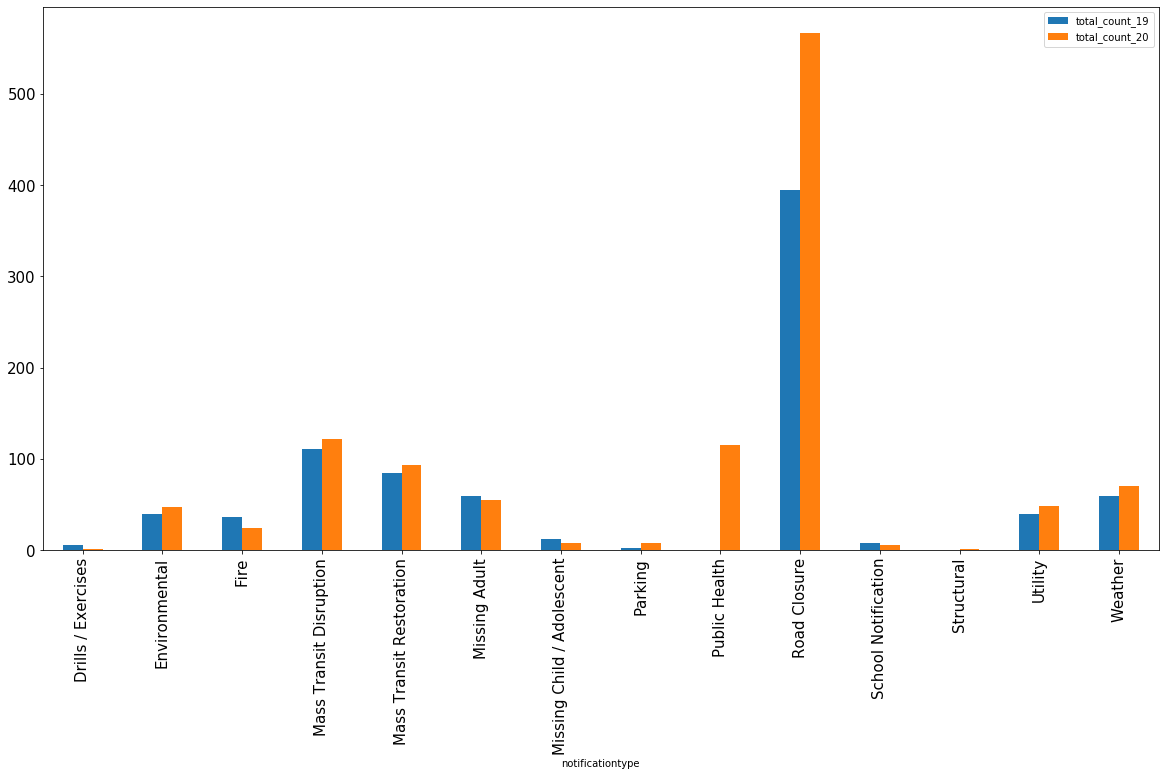

In [11]:
join_1920.plot(x="notificationtype", y=["total_count_19", "total_count_20"], kind="bar",figsize=(20,10),fontsize=15)

In [13]:
start_time='2020-02-28'
start_date=datetime.date(*map(int,start_time.split('-')))
df_start = emc_df[emc_df['date_and_time'].apply(lambda x: x > start_date)]
df_health = df_start[df_start["notificationtype"].apply(lambda x : x == "Public Health")]
words_list = ['COVID19','COVID-19','Coronavirus','COVID']
covid = df_health[df_health['notification_title'].str.contains('|'.join(words_list))]

In [14]:
covid['date_and_time'] = pd.to_datetime(covid['date_and_time']) - pd.to_timedelta(7, unit='d')
covid_by_week = covid.groupby([pd.Grouper(key='date_and_time', freq='W-MON')])['record_id'].count().reset_index().sort_values('date_and_time')

/Users/yuexi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
nyc_case_hosp = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv')

nyc_case_hosp.drop(columns= ['HOSPITALIZED_COUNT', 'DEATH_COUNT'],inplace=True)
nyc_case_hosp.rename(columns= {'DATE_OF_INTEREST':'Date', 'CASE_COUNT':'Newcase'}, inplace = True)
nyc_case_hosp['Date'] = pd.to_datetime(nyc_case_hosp['Date'])
nyc_case_hosp['Date'] = nyc_case_hosp['Date'].dt.date
df_confirmed_case = pd.DataFrame(columns=['date', 'case'])

In [16]:
df_confirmed_case = pd.DataFrame(columns=['date_and_time', 'case'])
for i in range(len(nyc_case_hosp)):
    if i == 0:
        df_confirmed_case = df_confirmed_case.append(pd.DataFrame({'date_and_time':[nyc_case_hosp['Date'][i]],'case':[nyc_case_hosp['Newcase'][i]]}),ignore_index=True)
    else:
        confirmed_case = df_confirmed_case['case'][i-1] + nyc_case_hosp['Newcase'][i]
        df_confirmed_case = df_confirmed_case.append(pd.DataFrame({'date_and_time':[nyc_case_hosp['Date'][i]],'case':[confirmed_case]}),ignore_index=True)

In [18]:
df_confirmed_case['date_and_time'] = pd.to_datetime(df_confirmed_case['date_and_time']) - pd.to_timedelta(7, unit='d')
confirm_by_week = df_confirmed_case.groupby([pd.Grouper(key='date_and_time', freq='W-MON')])['case'].sum().reset_index().sort_values('date_and_time')

In [19]:
covid_by_week.rename(columns={'record_id':'count'}, inplace=True)
covid_by_week.rename(columns={'count':'notfication_count'}, inplace=True)
covid_by_week

,date_and_time,notfication_count
0,2020-03-02,4
1,2020-03-09,9
2,2020-03-16,14
3,2020-03-23,16
4,2020-03-30,16
5,2020-04-06,20
6,2020-04-13,10
7,2020-04-20,7
8,2020-04-27,13
9,2020-05-04,3


In [20]:
index = covid_by_week['date_and_time']
joint = confirm_by_week.join(covid_by_week.set_index('date_and_time'), on='date_and_time')
joint

,date_and_time,case,notfication_count
0,2020-02-24,5,NaN
1,2020-03-02,221,4.0
2,2020-03-09,12481,9.0
3,2020-03-16,121195,14.0
4,2020-03-23,314522,16.0
5,2020-03-30,552274,16.0
6,2020-04-06,790133,20.0
7,2020-04-13,962135,10.0
8,2020-04-20,1099280,7.0
9,2020-04-27,1194907,13.0


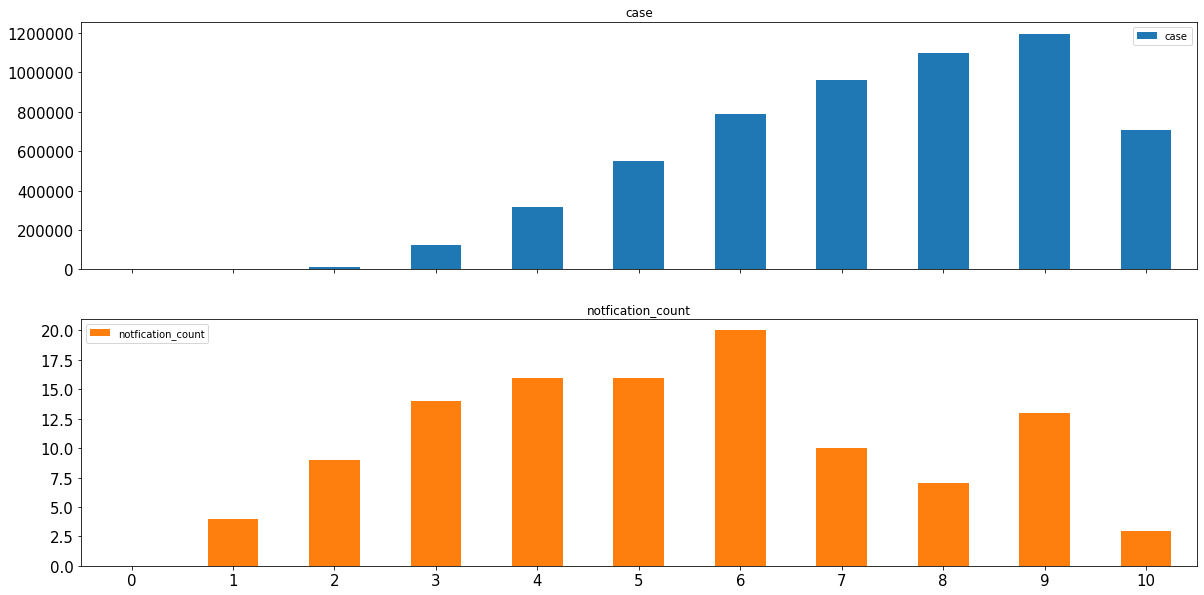

In [21]:
joint['date_and_time'] = joint['date_and_time'].dt.date
axes = joint.plot.bar(rot=0, subplots=True, figsize=(20,10),fontsize=15)
axes[1].legend(loc=2)  